In [9]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'seller'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Agra@123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/keshavmittal/Downloads/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    username ='root',
    password='Agra@123',
    database='ecommerce')

cur = db.cursor()


# List all unique cities where customers are located. 

In [3]:
query = """select distinct customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]

# Count the number of orders placed in 2017. 

In [12]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()
data[0][0]



225505

# find total sales per category 

In [30]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","Sales"])
df

Category        Sales
0                     PERFUMERY  24323455.67
1          FURNITURE DECORATION  68648466.81
2                     TELEPHONY  23370338.43
3                BED TABLE BATH  82202576.21
4                    AUTOMOTIVE  40910127.89
..                          ...          ...
69               CDS MUSIC DVDS     57572.64
70                   LA CUISINE    139849.44
71  FASHION CHILDREN'S CLOTHING     37712.16
72                     PC GAMER    104372.64
73       INSURANCE AND SERVICES     15576.48

[74 rows x 2 columns]

# Calculate the percentage of orders that were paid in installments.

In [32]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))
/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data[0][0]


Decimal('99.9981')

# count number of customer from each state

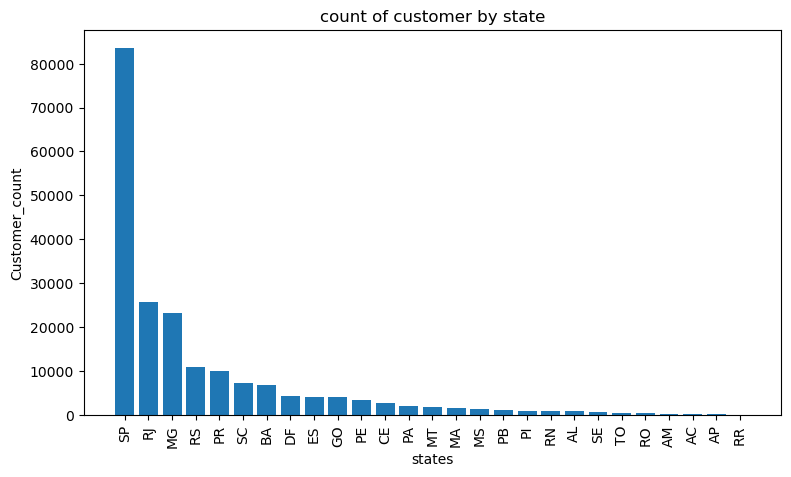

In [40]:
query = """ select count(customer_id),customer_state from customers 
group by customer_state"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["count","state"])
df = df.sort_values(by = "count",ascending = False)
plt.figure(figsize = (9,5))
plt.bar(df["state"],df["count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("Customer_count")
plt.title("count of customer by state")
plt.show()

# Calculate the number of orders per month in 2018.


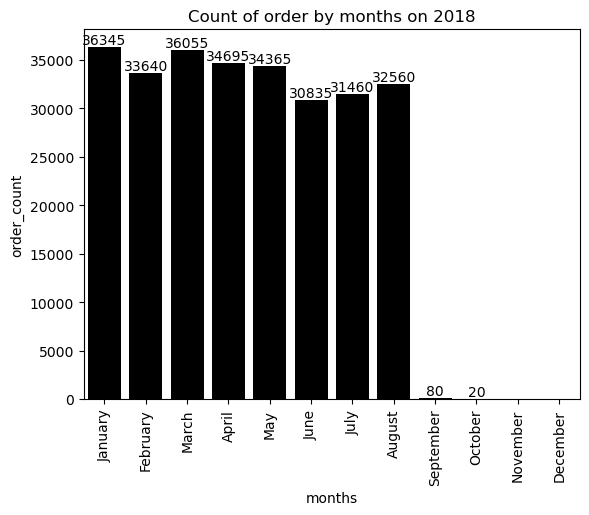

In [18]:

query = """ select monthname(order_purchase_timestamp) months,
count(order_id) order_count
from orders
where order_purchase_timestamp = 2018
group by months"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August",
     "September","October","November","December"]
ax = sns.barplot(x = df["months"],y = df["order_count"],data = df, order = o, color = "black")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Count of order by months on 2018")
plt.show()



# Find the average number of products per order, grouped by customer city.


In [43]:
query = """with count_per_order as (
select 
orders.order_id, 
orders.customer_id,
count(order_items.order_id) as oc
from orders 
join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select 
customers.customer_city, 
round(avg(count_per_order.oc),2)
from customers 
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


0      1
0            treze tilias  19.09
1                 indaial  16.73
2     sao jose dos campos  17.08
3               sao paulo  17.34
4            porto alegre  17.62
...                   ...    ...
4105             guairaca  30.00
4106             sambaiba  15.00
4107           japaratuba  15.00
4108               tuiuti  15.00
4109         tibau do sul  15.00

[4110 rows x 2 columns]

# Calculate the percentage of total revenue contributed by each product category.

In [65]:
query = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales desc"""

cur.execute (query)
data = cur.fetchall( )
df = pd.DataFrame(data,columns = ["Category" ,"Sales percent"])
df.head(10)

Category  Sales percent
0        BED TABLE BATH         128.37
1         HEALTH BEAUTY         124.23
2  COMPUTER ACCESSORIES         118.83
3  FURNITURE DECORATION         107.20
4       WATCHES PRESENT         107.13
5         SPORT LEISURE         104.35
6            HOUSEWARES          82.06
7            AUTOMOTIVE          63.89
8          GARDEN TOOLS          62.84
9            COOL STUFF          58.44

# Identify the correlation between product price and the number of times a product has been purchased.


In [77]:
query = """select count(order_items.order_item_id) order_count,
round(avg(order_items.price),2) price,
upper(products.product_category) category 
from order_items join products 
on order_items.product_id = products.product_id
group by category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["order count","price","category"] )
df

arr1 = df["order count"]
arr2 = df["price"]
np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

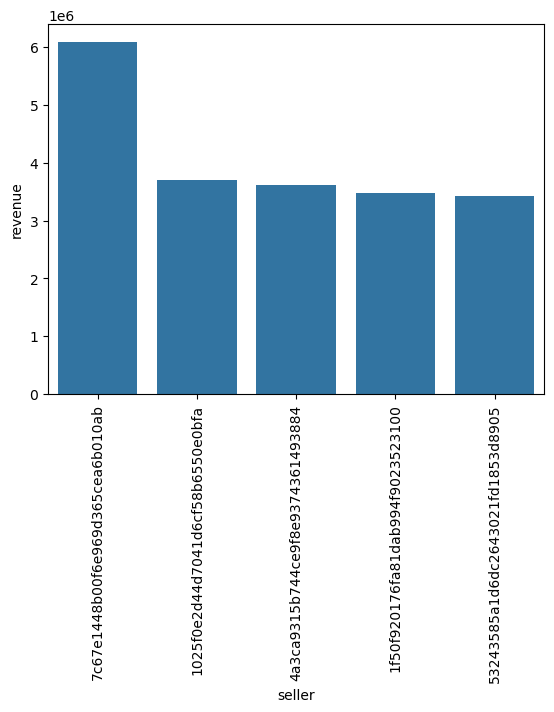

In [118]:
query = """select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,
sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller", "revenue","rank"])
df = df.head( )
sns.barplot(x = "seller", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [141]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp ,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as sub"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

0                    1       2  \
0        00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
1        00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
2        00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
3        00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
4        00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
...                                   ...                  ...     ...   
2077715  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
2077716  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
2077717  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
2077718  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
2077719  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   

                  3  
0        114.739998  
1        114.739998  
2        114.739998  
3        114.739998  
4        114.739998  
...             ...  
2077715   18.370001  
2077716   18.370001  
2077717   18.370001  
2077718   18.370001  
2077719   18.370001  

[2077720 rows x 4 columns]

# Calculate the cumulative sales per month for each year.

In [139]:
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value)) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

0   1           2            3
0   2016   9      5045.0       5045.0
1   2016  10   1181810.0    1186855.0
2   2016  12       392.0    1187247.0
3   2017   1   2769761.0    3957008.0
4   2017   2   5838160.0    9795168.0
5   2017   3   8997272.0   18792440.0
6   2017   4   8355761.0   27148201.0
7   2017   5  11858376.0   39006577.0
8   2017   6  10225528.0   49232105.0
9   2017   7  11847658.0   61079763.0
10  2017   8  13487926.0   74567689.0
11  2017   9  14555249.0   89122938.0
12  2017  10  15593558.0  104716496.0
13  2017  11  23897656.0  128614152.0
14  2017  12  17568030.0  146182182.0
15  2018   1  22300084.0  168482266.0
16  2018   2  19849267.0  188331533.0
17  2018   3  23193042.0  211524575.0
18  2018   4  23215710.0  234740285.0
19  2018   5  23079643.0  257819928.0
20  2018   6  20477610.0  278297538.0
21  2018   7  21330815.0  299628353.0
22  2018   8  20448506.0  320076859.0
23  2018   9     88791.0  320165650.0
24  2018  10     11793.0  320177443.0

# Calculate the year-over-year growth rate of total sales.


In [152]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value)) as payments
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payments - lag(payments,1) over (order by years))
/ lag(payments,1) over (order by years))*100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy% growth"])
df

years   yoy% growth
0   2016           NaN
1   2017  12112.701738
2   2018     20.000923

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [162]:
query = """with a as (select customers.customer_id ,
min(orders.order_purchase_timestamp) first_order
from customers join orders 
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders 
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""


cur.execute(query)
data = cur.fetchall()
data


[(None,)]

# Identify the top 3 customers who spent the most money in each year.

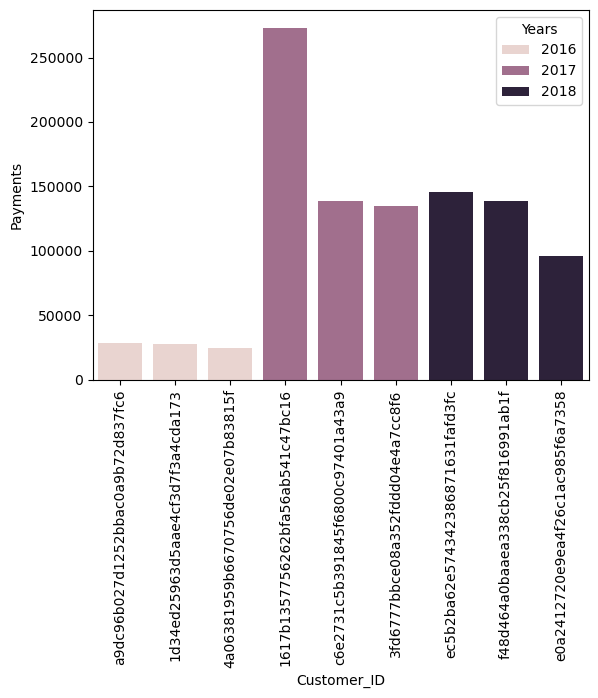

In [177]:
query = """select years, customer_id, payments,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payments,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by years,
orders.customer_id) as a
where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = [ "Years","Customer_ID","Payments","Rank"])
sns.barplot(x = "Customer_ID",y = "Payments",hue = "Years",data = df)
plt.xticks(rotation = 90)
plt.show()

